# Robbins Crater DB to Camera Frame

In [1]:
# Imports
import pandas as pd
import numpy as np
from numpy import pi,sin,cos,array,zeros,ones,dot,cross,deg2rad,arcsin,arctan2,rad2deg,sqrt
from numpy.linalg import norm
from matplotlib import pyplot as plt
import skimage.draw as draw
import skimage.measure as meas
import os
import cv2
import struct

/tmp/ipykernel_1906193/2641281025.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Reading in the data
data = "../data/lunar_crater_database_robbins_2018_bundle/data/lunar_crater_database_robbins_2018.csv"

dataset = pd.read_csv(data)

# Getting Crater Info
crater_info = dataset[["CRATER_ID","LAT_ELLI_IMG","LON_ELLI_IMG","DIAM_ELLI_MAJOR_IMG","DIAM_ELLI_MINOR_IMG","DIAM_ELLI_ANGLE_IMG","ARC_IMG"]]

In [3]:
# Looking at crater db
print(crater_info)

           CRATER_ID  LAT_ELLI_IMG  LON_ELLI_IMG  DIAM_ELLI_MAJOR_IMG  \
0        00-1-000000     -19.89050      264.6650            975.87400   
1        00-1-000001      44.40830      329.0460            289.44000   
2        00-1-000002      56.90000       81.6464            632.57100   
3        00-1-000003       1.95072      230.5880            568.52900   
4        00-1-000004     -49.18330      266.3530            665.24000   
...              ...           ...           ...                  ...   
1296791  10-2-014997     -65.62160      203.5380              7.05088   
1296792  10-3-000000     -60.03010      178.7120              8.31388   
1296793  10-3-000003     -66.79510      219.3470             13.98770   
1296794  10-3-000004     -79.84080       62.1830              7.31069   
1296795  10-3-000005     -79.70550       61.8818              8.97592   

         DIAM_ELLI_MINOR_IMG  DIAM_ELLI_ANGLE_IMG   ARC_IMG  
0                  905.96800             35.99190  0.568712  

In [4]:
# Removing all but Area of Interest
lat_search = [-90,90]
lon_search = [0,360]
craters = crater_info[(crater_info["LAT_ELLI_IMG"] < lat_search[1]) & (crater_info["LAT_ELLI_IMG"] > lat_search[0])]
if lon_search[0] > lon_search[1]:
	craters = craters[(craters["LON_ELLI_IMG"] > lon_search[0]) | (craters["LON_ELLI_IMG"] < lon_search[1])]
else:
	craters = craters[(craters["LON_ELLI_IMG"] > lon_search[0]) & (craters["LON_ELLI_IMG"] < lon_search[1])]
print(craters)

           CRATER_ID  LAT_ELLI_IMG  LON_ELLI_IMG  DIAM_ELLI_MAJOR_IMG  \
0        00-1-000000     -19.89050      264.6650            975.87400   
1        00-1-000001      44.40830      329.0460            289.44000   
2        00-1-000002      56.90000       81.6464            632.57100   
3        00-1-000003       1.95072      230.5880            568.52900   
4        00-1-000004     -49.18330      266.3530            665.24000   
...              ...           ...           ...                  ...   
1296791  10-2-014997     -65.62160      203.5380              7.05088   
1296792  10-3-000000     -60.03010      178.7120              8.31388   
1296793  10-3-000003     -66.79510      219.3470             13.98770   
1296794  10-3-000004     -79.84080       62.1830              7.31069   
1296795  10-3-000005     -79.70550       61.8818              8.97592   

         DIAM_ELLI_MINOR_IMG  DIAM_ELLI_ANGLE_IMG   ARC_IMG  
0                  905.96800             35.99190  0.568712  

In [5]:
# Removing Tiny and Massive Craters
sizes = [10,100000000]
craters = craters[(craters["DIAM_ELLI_MAJOR_IMG"]>sizes[0])&(craters["DIAM_ELLI_MAJOR_IMG"]<sizes[1])]
print(craters)
print(craters.shape)

           CRATER_ID  LAT_ELLI_IMG  LON_ELLI_IMG  DIAM_ELLI_MAJOR_IMG  \
0        00-1-000000     -19.89050      264.6650             975.8740   
1        00-1-000001      44.40830      329.0460             289.4400   
2        00-1-000002      56.90000       81.6464             632.5710   
3        00-1-000003       1.95072      230.5880             568.5290   
4        00-1-000004     -49.18330      266.3530             665.2400   
...              ...           ...           ...                  ...   
1296786  10-2-014992     -83.75820       68.5942              72.1062   
1296787  10-2-014993     -76.64950      192.9930              18.9654   
1296788  10-2-014994     -76.85250      190.7570              20.2091   
1296789  10-2-014995     -71.07770       46.5907              18.2006   
1296793  10-3-000003     -66.79510      219.3470              13.9877   

         DIAM_ELLI_MINOR_IMG  DIAM_ELLI_ANGLE_IMG   ARC_IMG  
0                   905.9680             35.99190  0.568712  

In [6]:
# Removing ellipses with incompleteness over %
min_arc = .7 # 80%
craters = craters[craters["ARC_IMG"]>min_arc]
print(craters)
print(craters.shape)

           CRATER_ID  LAT_ELLI_IMG  LON_ELLI_IMG  DIAM_ELLI_MAJOR_IMG  \
8        00-1-000008      -4.38541     202.55800             430.2210   
10       00-1-000010     -57.20190     135.52200             324.8680   
12       00-1-000012     -52.24310     178.16900            2612.5700   
14       00-1-000014     -22.45730     344.52900             735.9030   
15       00-1-000015      26.16020     147.41400             442.0500   
...              ...           ...           ...                  ...   
1296151  10-2-014334     -73.53880     138.24300              10.3420   
1296558  10-2-014757     -62.29590     220.79200              19.2651   
1296782  10-2-014986     -60.34110       8.36253              10.3607   
1296783  10-2-014987     -61.29530      11.27400              12.6677   
1296793  10-3-000003     -66.79510     219.34700              13.9877   

         DIAM_ELLI_MINOR_IMG  DIAM_ELLI_ANGLE_IMG   ARC_IMG  
8                  426.39400             80.01410  0.741016  

In [7]:
# Prepping data for loading in
crater_data = craters[["LAT_ELLI_IMG","LON_ELLI_IMG","DIAM_ELLI_MAJOR_IMG","DIAM_ELLI_MINOR_IMG","DIAM_ELLI_ANGLE_IMG","ARC_IMG"]]
np_craters = crater_data.to_numpy()
print(np_craters)

[[-4.38541e+00  2.02558e+02  4.30221e+02  4.26394e+02  8.00141e+01
   7.41016e-01]
 [-5.72019e+01  1.35522e+02  3.24868e+02  3.12342e+02  2.85855e+01
   7.39815e-01]
 [-5.22431e+01  1.78169e+02  2.61257e+03  2.37325e+03  1.55272e+02
   7.97656e-01]
 ...
 [-6.03411e+01  8.36253e+00  1.03607e+01  9.06679e+00  2.93677e+01
   7.87219e-01]
 [-6.12953e+01  1.12740e+01  1.26677e+01  1.14961e+01  1.66652e+02
   7.10885e-01]
 [-6.67951e+01  2.19347e+02  1.39877e+01  9.96860e+00  4.17107e+01
   8.50627e-01]]


In [8]:
# DCM Creators

def DCM_ZYX(a1,a2,a3):
	dcm = np.zeros((3,3))
	dcm[0,0] = np.cos(a1)*np.cos(a2)
	dcm[0,1] = np.cos(a2)*np.sin(a1)
	dcm[0,2] = -np.sin(a2)
	dcm[1,0] = (np.cos(a1)*np.sin(a2)*np.sin(a3))-(np.cos(a3)*np.sin(a1))
	dcm[1,1] = (np.cos(a1)*np.cos(a3))+(np.sin(a1)*np.sin(a2)*np.sin(a3))
	dcm[1,2] = np.cos(a2)*np.sin(a3)
	dcm[2,0] = (np.sin(a1)*np.sin(a3))+(np.cos(a1)*np.cos(a3)*np.sin(a2))
	dcm[2,1] = (np.cos(a3)*np.sin(a1)*np.sin(a2))-(np.cos(a1)*np.sin(a3))
	dcm[2,2] = np.cos(a2)*np.cos(a3)
	#print(dcm)
	return dcm


In [9]:
# Adding Camera plane
MOON_RADIUS = 1737.4 # km
img = np.zeros((1024,1024)) # Camera Generated in Blender
f = .1021 # meters
sensor_width = .036 # meters
du = sensor_width/img.shape[0] # meters
dv = sensor_width/img.shape[1] # meters
center = (np.array(img.shape)/2).astype(int)
print(center)

def get_Z_CAM(P_CAM,radius,s_dim,fov):
	A = np.linalg.norm(P_CAM)
	B = radius
	delta = fov/s_dim
	betas = np.arange(-fov/2+(delta/2),fov/2+(delta/2),fov/s_dim)
	betas = np.abs(betas)
	betas = np.deg2rad(betas)
	alphas = np.arcsin((A/B)*np.sin(betas))
	alphas = np.where(alphas>np.pi/2,alphas,np.pi-alphas)
	gammas = np.pi - betas - alphas
	#print(gammas)
	zs_moon = B*np.cos(gammas).reshape(s_dim,1)
	norm_zs_moon = zs_moon/np.max(zs_moon)
	print(norm_zs_moon)
	Z_CAM = (A - zs_moon@norm_zs_moon.T)
	print(Z_CAM)
	print(np.min(Z_CAM),np.max(Z_CAM))
	return Z_CAM

def ellipse_dist(center,du,dv,f,Z_CAM,P_CAM,c2m,m2e,a,b):
	uv = np.zeros((1024,1024,3))
	uv[:,:,0] = np.repeat(np.arange(0.5,1024.5,1).reshape(1024,1),1024,axis=0).reshape(1024,1024)
	uv[:,:,1] = np.repeat(np.arange(1023.5,-0.5,-1).reshape(1,1024),1024,axis=0).reshape(1024,1024)
	UV = (uv-np.array([center[0],center[1],0])) * np.array([du,-dv,1])
	#Z_CAM = np.abs(np.linalg.norm(P_CAM))-MOON_RADIUS
	XYZ_CAM = UV*Z_CAM.reshape(img.shape[0],img.shape[1],1)/f
	XYZ_CAM[:,:,2] = -XYZ_CAM[:,:,0]
	XYZ_CAM[:,:,0] = Z_CAM

	XYZ_LINE = np.transpose(XYZ_CAM,axes=[2,0,1]).reshape(3,1024**2)
	
	P_MOON = -c2m@XYZ_LINE + np.repeat(P_CAM,1024**2).reshape(3,1024**2)

	P_ELL = m2e@P_MOON

	P_ELL = np.transpose(P_ELL).reshape(1024,1024,3)

	ELL_DIFF = P_ELL[:,:,1:]

	dists = np.power(np.abs((ELL_DIFF[:,:,0]**2/a**2) + (ELL_DIFF[:,:,1]**2/b**2) - 1),1/2)

	return dists 

[512 512]


In [10]:
# Convert to Camera Frame
cam_ra = 0	# degrees
cam_decl = 0	# degrees
cam_range = 3237.4 # km
MOON_RADIUS = 1737.4 # km
K = np.array([0,0,1]) # Axis of Rotation, Pointing North

ra = np.deg2rad(-cam_ra)
decl = np.deg2rad(cam_decl)

print("RA:   {}\nDECL: {}".format(ra,decl))

T_CAM_MOON = DCM_ZYX(ra,decl,0)

P_CAM = T_CAM_MOON@(np.array([cam_range,0,0]))

print("CAMERA_POSITION:\n{}".format(P_CAM))

img = np.zeros((1024,1024))

Z_CAM = get_Z_CAM(P_CAM,MOON_RADIUS,img.shape[0],20)

for idx, crater in enumerate(np_craters):
	#if idx > 10:
		#break
	lat = np.deg2rad(crater[0])
	lon = np.deg2rad(crater[1])
	angle = np.deg2rad(crater[4])
	a = crater[2]/2
	b = crater[3]/2
	x0 = MOON_RADIUS*np.cos(lon)*np.cos(lat)
	y0 = MOON_RADIUS*np.sin(lon)*np.cos(lat)
	z0 = MOON_RADIUS*np.sin(lat)
	p0 = np.array([x0,y0,z0])
	p_hat = p0/np.linalg.norm(p0)
	east_hat = -(np.cross(p_hat,K))
	north_hat = np.cross(p_hat,east_hat)

	T_MOON_ELLIPSE = DCM_ZYX(-lon,lat,angle)

	dists = ellipse_dist(center,du,dv,f,Z_CAM,P_CAM,T_CAM_MOON,T_MOON_ELLIPSE,a,b)
	if np.min(dists) > 1:
		continue
	dist_render = dists
	print("Crater {}: Min Value: {}".format(idx,np.min(dists)))
	dist_render[dist_render>1] = 1
	diff = 1-np.min(dists)
	dist_render = (255*((1/diff)*(1-dist_render))).astype(int)
	dist_render[dist_render < 200] = 0
	dist_render[dist_render > 0] = 255
	img = np.where(dist_render > img,dist_render,img)

plt.style.use("grayscale")
plt.imshow(img)
plt.imsave("test.png",img)

RA:   0.0
DECL: 0.0
CAMERA_POSITION:
[3237.4    0.     0. ]
[[0.9880415 ]
 [0.9880908 ]
 [0.98813999]
 ...
 [0.98813999]
 [0.9880908 ]
 [0.9880415 ]]
[[1541.30497229 1541.22033128 1541.13589288 ... 1541.13589288
  1541.22033128 1541.30497229]
 [1541.22033128 1541.13568604 1541.05124343 ... 1541.05124343
  1541.13568604 1541.22033128]
 [1541.13589288 1541.05124343 1540.96679662 ... 1540.96679662
  1541.05124343 1541.13589288]
 ...
 [1541.13589288 1541.05124343 1540.96679662 ... 1540.96679662
  1541.05124343 1541.13589288]
 [1541.22033128 1541.13568604 1541.05124343 ... 1541.05124343
  1541.13568604 1541.22033128]
 [1541.30497229 1541.22033128 1541.13589288 ... 1541.13589288
  1541.22033128 1541.30497229]]
1500.0000188108122 1541.3049722886035
Crater 2: Min Value: 0.0005791766234111877


KeyboardInterrupt: 

In [72]:
def wahbas_problem(from_los, to_los, W=None):
	"""
		Here it is, in all of its majesty...
	"""
	if W is None:
		W = np.eye(from_los.shape[0])
	E = from_los.T@W
	A = to_los.T@W
	B = A@E.T
	U,S,V = np.linalg.svd(B)
	M = np.eye(3)
	M[2,2] = np.linalg.det(U)*np.linalg.det(V.T)
	return U@M@V


def rot_about(a,b,theta):
	a_par_b = (dot(a,b)/dot(b,b))*b
	a_perp_b = a - a_par_b
	w = cross(b,a_perp_b)
	x1 = cos(theta)/np.linalg.norm(a_perp_b)
	x2 = sin(theta)/np.linalg.norm(w)
	a_perp_btheta = np.linalg.norm(a_perp_b)*(x1*a_perp_b+x2*w)
	return array(a_perp_btheta + a_par_b)


def get_pos_los(ra,decl,alt):
	ra = deg2rad(ra)
	decl = deg2rad(decl)
	pos = array([alt*cos(ra)*cos(decl),
							 alt*sin(ra)*cos(decl),
							 alt*sin(decl)])
	los = -pos/np.linalg.norm(pos)
	return pos, los


def getPOSandDCMfromMOON(ra,decl,altitude):
	pos, global_z = get_pos_los(ra,decl,altitude)
	global_z = -global_z
	global_x = array([cos(deg2rad(ra+90)),sin(deg2rad(ra+90)),0])
	global_y = cross(global_z,global_x) #rot_about(global_z,global_x,-pi/2)
	local_z = array([0,0,1])
	local_x = array([1,0,0])
	local_y = array([0,1,0])
	T_MOON_OBJ = wahbas_problem(array([global_z,global_x,global_y]),
												array([local_z,local_x,local_y]))
	return pos, T_MOON_OBJ

def getCamPOSandDCMfromMOON(ra,decl,altitude):
	pos, global_z = get_pos_los(ra,decl,altitude)
	global_x = array([cos(deg2rad(ra+90)),sin(deg2rad(ra+90)),0])
	global_y = cross(global_z,global_x) #rot_about(global_z,global_x,pi/2)
	local_z = array([0,0,1])
	local_x = array([1,0,0])
	local_y = array([0,1,0])
	T_MOON_OBJ = wahbas_problem(array([global_z,global_x,global_y]),
												array([local_z,local_x,local_y]))
	return pos, T_MOON_OBJ


In [73]:
# Copied from moon mesh code
U_PIXELS = 92160
V_PIXELS = 46080
dem_file = "../images/big_dem.tif"
dem = None
nom_rad = 1737400
scale = 1e-3

def open_dem(filename):
	"""
		Reads in the TIF DEM file, converts to bin for easy parsing,
		without having to keep the whole thing in memory. Defines 
		width and height of the sphere in pixels.
	"""
	global dem
	bin_name = filename.replace(".tif",".bin")
	if not os.path.exists(bin_name):
		img = cv2.imread(filename,2)
		height, width = img.shape
		dem = open(bin_name,"wb+")
		for j in range(height):
			for i in range(width):
				dem.write(struct.pack("h",img[j][i]))
		dem.close()
		del img
	dem = open(bin_name,"rb")
	return


def get_pixel(u,v):
	"""
		Gets the current pixel value from the binary file
	"""
	global dem
	dem.seek(2*(U_PIXELS*v+u))
	return struct.unpack("h",dem.read(2))[0]


def get_height(u,v):
	"""
		Gets the Moon height at the given pixel coords.
	"""
	global scale, nom_rad
	return scale*(nom_rad+0.5*get_pixel(u,v))


def ijk2moonuv(ijk):
	r = np.linalg.norm(ijk)
	decl = arcsin(max(-1,min(ijk[2]/r,1)))
	if abs(cos(decl)) < 1e-10:
		ra = 0
	else:
		ra = arctan2(ijk[1]/(r*cos(decl)),ijk[0]/(r*cos(decl)))
	u = ((U_PIXELS-1)/2)+(U_PIXELS/360.*rad2deg(ra))
	v = ((V_PIXELS-1)/2)-(V_PIXELS/180.*rad2deg(decl))
	return u,v


def get_moon_height(pos):
	u,v = ijk2moonuv(pos)
	#print(u,v)
	return get_height(int(u),int(v))


In [74]:
# Light Mask
filename = "lightblur.png"
light = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
light = np.where(light==255,1,0)
print(light)

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


CAMERA_POSITION:
[ 4.54747351e-13 -0.00000000e+00  3.23740000e+03]
[-1.33227577e+03  5.12500000e+02  1.00000000e+00]
[-1.33865297e+03  5.12500000e+02  1.00000000e+00]
[-3.15576163e+06  9.23540972e+05  2.36870000e+03]
[-1.33227577e+03  3.89893601e+02  1.00000000e+00]
Lat: -4.385 Lon: 202.558
*Pink Floyd Intensifies*
Lat: -57.202 Lon: 135.522
Offscreen, don't care
Lat: -52.243 Lon: 178.169
*Pink Floyd Intensifies*
Lat: -22.457 Lon: 344.529
Offscreen, don't care
Lat: 26.160 Lon: 147.414
Offscreen, don't care
Lat: 61.037 Lon: 187.864
*Pink Floyd Intensifies*
Lat: 60.976 Lon: 185.599
*Pink Floyd Intensifies*
Lat: 60.810 Lon: 183.047
*Pink Floyd Intensifies*
Lat: 61.251 Lon: 178.485
*Pink Floyd Intensifies*
Lat: 60.942 Lon: 176.478
*Pink Floyd Intensifies*
Lat: 61.894 Lon: 180.173
*Pink Floyd Intensifies*
Lat: 61.527 Lon: 173.070
*Pink Floyd Intensifies*
Lat: 60.888 Lon: 165.812
*Pink Floyd Intensifies*
Lat: 61.249 Lon: 166.652
*Pink Floyd Intensifies*
Lat: 60.543 Lon: 160.114
*Pink Floyd In

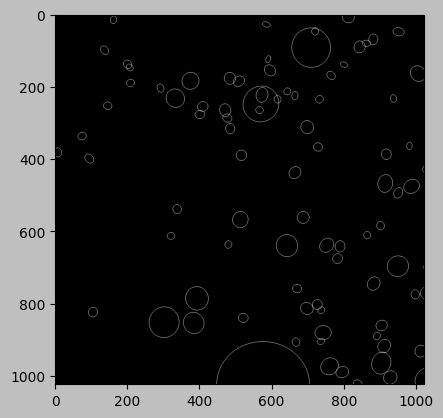

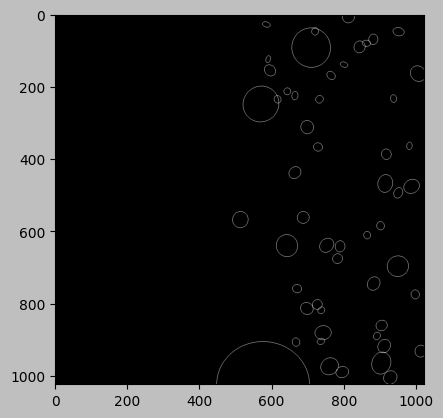

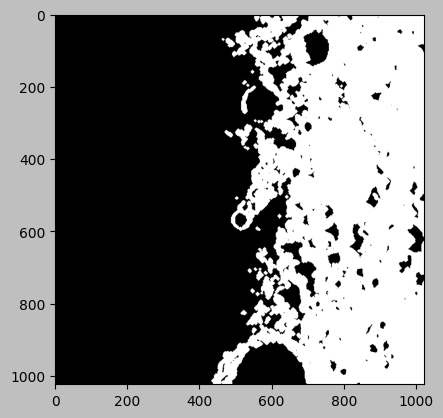

In [82]:
# Convert to Camera Frame
cam_ra = 60	# degrees
cam_decl = 0	# degrees
cam_range = 3237.4 # km
MOON_RADIUS = 1737.4 # km
f = .1021 # meters
sensor_width = .036 # meters
img = np.zeros((1024,1024))
du = img.shape[0]/sensor_width # meters
dv = img.shape[1]/sensor_width # meters
center = (np.array(img.shape)/2) + np.array([0.5,0.5])
crater_scale = 1

open_dem(dem_file)

ra = np.deg2rad(-cam_ra)
decl = np.deg2rad(cam_decl)

#print("RA: {}\nDECL: {}".format(ra,decl))

cam_pos,T_MOON_CAM = getCamPOSandDCMfromMOON(cam_ra,cam_decl,cam_range)

print("CAMERA_POSITION:\n{}".format(-(T_MOON_CAM@cam_pos)))

K_CAM = np.array([[f*du,0,center[0]],[0,f*dv,center[1]],[0,0,1]])
#print(K_CAM)
Rt_inter = np.zeros(shape=(3,4))
Rt_inter[:,:3] = T_MOON_CAM
Rt_inter[:,3] = -(T_MOON_CAM@cam_pos)
#print(Rt_inter)
M_CAM = K_CAM@Rt_inter
#print(M_CAM)

## Testing camera matrix
t1=M_CAM@array([1737.4,0,0,1])
t1 = t1/t1[2]
print(t1)

t2=M_CAM@array([1737.4,100,0,1])
t2 = t2/t2[2]
print(t2)

t3=M_CAM@array([1737.4,0,100,1])
print(t3)
t3 = t3/t3[2]
print(t3)

lit_img = np.zeros((1024,1024))

#sadf#

for idx, crater in enumerate(np_craters):
	#if idx > 10:
		#break
	lat = crater[0]
	lon = crater[1]
	angle = np.deg2rad(crater[4])
	a = crater[2]/2
	b = crater[3]/2

	is_lit=False

	print("Lat: {:.3f} Lon: {:.3f}".format(lat,lon))

	crater_pos, T_MOON_ELLIPSE = getPOSandDCMfromMOON(lon,lat,MOON_RADIUS)
	# Check for not visible
	hom_crater_pos = np.ones(shape=(4,))
	hom_crater_pos[:3] = crater_pos
	cam_crater_pos = M_CAM@hom_crater_pos
	if cam_crater_pos[2] > cam_range:
		print("*Pink Floyd Intensifies*")
		continue
	#print("Crater Pos: {}".format(crater_pos))
	cam_pts = []
	#print("Angle is: {:.3f}".format(angle))
	#print(crater_pos)
	radius = get_moon_height(crater_pos)
	#print("Radius: {}".format(radius))
	for i in [0,np.pi/4,np.pi/2,3*np.pi/4,np.pi,5*np.pi/4,3*np.pi/2,7*np.pi/4]:
		xp = a*cos(angle)*cos(i)-b*sin(angle)*sin(i)
		yp = a*sin(angle)*cos(i)+b*cos(angle)*sin(i)
		zp = sqrt(radius**2-(xp**2+yp**2))
		ellipse_pt = np.array([xp,yp,zp])
		#print("MOON_POINT: {}".format(T_MOON_ELLIPSE.T@ellipse_pt))
		pt_radius = get_moon_height(T_MOON_ELLIPSE.T@ellipse_pt)
		ellipse_pt[2] = pt_radius #sqrt(pt_radius**2-xp**2-yp**2)
		#print("Angle = {:.3f}: Pt = {}".format(i,ellipse_pt))
		cam_pts.append(ellipse_pt)
	cam_pts = np.array(cam_pts).reshape(8,3)
	#print(cam_pts)
	moon_pts = (T_MOON_ELLIPSE.T@cam_pts.T).T
	#print(moon_pts)
	#break
	hom_moon_pts = np.ones(shape=(8,4))
	hom_moon_pts[:,:3] = moon_pts
	#print(hom_moon_pts)
	cam_pts = (M_CAM@hom_moon_pts.T).T
	#print(cam_pts)
	#break
	cam_pts /= cam_pts[:,2].reshape(8,1)
	cam_pts = cam_pts[:,:2]
	cam_pts = np.round(cam_pts,0).astype(int)
	cam_pts[:,[0,1]] = cam_pts[:,[1,0]]
	if (np.max(np.min(cam_pts,axis=0))>img.shape[0] or np.min(np.max(cam_pts,axis=0))<0):
		print("Offscreen, don't care")
		continue
	#print(cam_pts)
	#img[cam_pts[:,0],cam_pts[:,1]] = 255
	#break
	#"""
	if np.unique(cam_pts,axis=0).shape[0]<8:
		print("Flat line!")
		continue
	abs_d = np.abs(cam_pts-img.shape[0]/2)
	#print(abs_d)
	max_d = np.max(abs_d,axis=1)
	idxs = np.where(max_d<img.shape[0]/2)
	#print(idxs)
	frame_pts = cam_pts[idxs[0],:]
	if frame_pts.shape[0] >=3:
		#print(frame_pts)
		lit_count = np.sum(light[frame_pts[:,0],frame_pts[:,1]])
		#print(lit_count)
		if lit_count >= 4:
			is_lit = True
	ellipse = meas.EllipseModel()
	print(cam_pts)
	passed = ellipse.estimate(cam_pts)
	#print(passed)
	if not passed:
		continue
	print(ellipse.params)
	r,c,rr,cr,theta = ellipse.params
	ellipse.estimate(cam_pts)
	print(ellipse.params)
	r = int(round(r,0))
	c = int(round(c,0))
	rr = int(round(rr,0))
	cr = int(round(cr,0))
	if rr <=0 or cr <=0:
		continue
	rr,cc = draw.ellipse_perimeter(r,c,rr,cr,-theta)
	rr = np.round(rr).astype(int)
	cc = np.round(cc).astype(int)
	#print(rr,cc)
	abs_rr = np.abs(rr-img.shape[0]/2)
	abs_cc = np.abs(cc-img.shape[0]/2)
	maxm = np.max([abs_rr,abs_cc],axis=0)
	idxs = np.where(maxm<img.shape[0]/2)
	rr = rr[idxs]
	cc = cc[idxs]
	img[rr,cc] = 255
	if is_lit:
		lit_img[rr,cc] = 255
	#break
	#"""

plt.style.use("grayscale")
plt.figure()
plt.imshow(img)
plt.imsave("test_redux.png",lit_img)
plt.figure()
plt.imshow(lit_img)
plt.figure()
plt.imshow(light)
dem.close()